<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           774 non-null    datetime64[ns]
 1   CRUDE_PETRO    774 non-null    float64       
 2   CRUDE_BRENT    774 non-null    float64       
 3   CRUDE_DUBAI    774 non-null    float64       
 4   CRUDE_WTI      774 non-null    object        
 5   COAL_AUS       774 non-null    object        
 6   COAL_SAFRICA   774 non-null    object        
 7   NGAS_US        774 non-null    float64       
 8   NGAS_EUR       774 non-null    float64       
 9   NGAS_JP        774 non-null    object        
 10  iNATGAS        774 non-null    object        
 11  COCOA          774 non-null    float64       
 12  COFFEE_ARABIC  774 non-null    float64       
 13  COFFEE_ROBUS   774 non-null    float64       
 14  TEA_AVG        774 non-null    float64       
 15  TEA_COLOMBO    774 non-

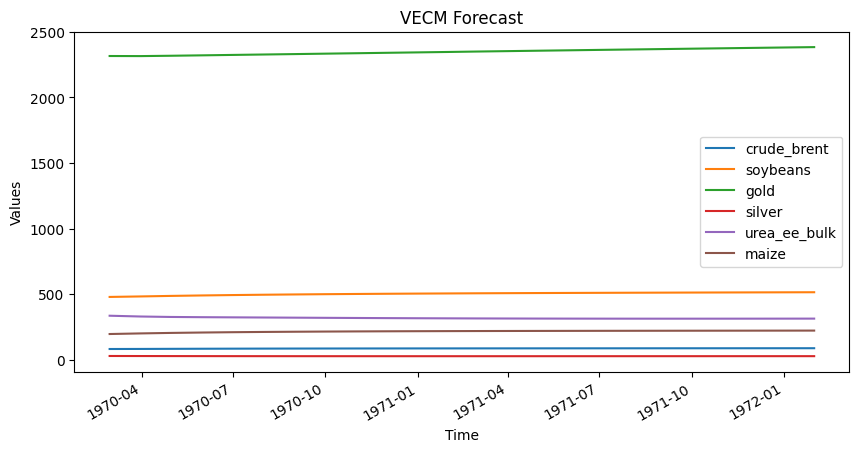

In [6]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('pinksheet.xlsx', sheet_name="Monthly Prices", skiprows=6)

# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'].astype(str) + '01', format='%YM%m%d')
print(df.info())  # Check the structure of the dataframe

# Select specific columns (Date and selected commodities)
commodity = df[['Date', 'CRUDE_BRENT', 'SOYBEANS', 'GOLD', 'SILVER', 'UREA_EE_BULK', 'MAIZE']]

# Clean column names (optional, as Pandas automatically handles column names well)
commodity.columns = commodity.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

print(commodity.info())  # Check the structure of the cleaned dataframe

# Remove the Date column for analysis
commodity_data = commodity.drop(columns=['date'])

# Column names to test (if you want to specify particular columns)
columns_to_test = commodity_data.columns

# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

# Loop through each column and perform the ADF test
for col in columns_to_test:
    adf_result = adfuller(commodity_data[col])
    p_value = adf_result[1]  # Extract p-value for the test
    print(f"\nADF test result for column: {col}\n")
    print(f"Test Statistic: {adf_result[0]}")
    print(f"P-value: {p_value}")
    print(f"Critical Values: {adf_result[4]}")

    # Check if the p-value is greater than 0.05 (commonly used threshold)
    if p_value > 0.05:
        non_stationary_count += 1
        non_stationary_columns.append(col)
    else:
        stationary_columns.append(col)

# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}\n")
print(f"Non-stationary columns: {non_stationary_columns}\n")
print(f"Stationary columns: {stationary_columns}")

# Co-Integration Test (Johansen's Test)
# Perform Johansen's Co-Integration Test
johansen_test = coint_johansen(commodity_data, det_order=0, k_ar_diff=1)

# Summary of the Co-Integration Test
print("\nJohansen Test Results:\n")
print(f"Eigenvalues:\n{johansen_test.eig}\n")
print(f"Trace Statistic:\n{johansen_test.lr1}\n")
print(f"Critical Values (5% level):\n{johansen_test.cvt[:, 1]}\n")

# Determine the number of co-integrating relationships (r) based on the test
r = 2  # Replace with the actual number from the test results

if r > 0:
    # If co-integration exists, estimate the VECM model
    vecm_model = VECM(commodity_data, k_ar_diff=1, coint_rank=r, deterministic='co')
    vecm_fitted = vecm_model.fit()

    # Summary of the VECM model
    print(vecm_fitted.summary())

    # Extracting coefficients from the VECM model
    print("Alpha Coefficients:\n", vecm_fitted.alpha)
    print("Beta Coefficients:\n", vecm_fitted.beta)
    print("Gamma Coefficients:\n", vecm_fitted.gamma)

    # Forecasting using the VECM model
    forecast = vecm_fitted.predict(steps=24)

    # Convert forecast to a DataFrame for plotting
    forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=commodity_data.index[-1], periods=25, freq='M')[1:], columns=commodity_data.columns)

    # Plotting the forecast
    forecast_df.plot(figsize=(10, 5))
    plt.title('VECM Forecast')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

else:
    # If no co-integration exists, proceed with Unrestricted VAR Analysis
    var_model = VAR(commodity_data)
    var_fitted = var_model.fit(maxlags=10, ic='aic')

    # Summary of the VAR model
    print(var_fitted.summary())

    # Granger causality test
    for col in commodity_data.columns:
        granger_result = var_fitted.test_causality(causing=col, caused=[c for c in commodity_data.columns if c != col])
        print(f"Granger causality test for {col}:\n", granger_result.summary())

    # Forecasting using the VAR model
    var_forecast = var_fitted.forecast(var_fitted.y, steps=24)
    var_forecast_df = pd.DataFrame(var_forecast, index=pd.date_range(start=commodity_data.index[-1], periods=25, freq='M')[1:], columns=commodity_data.columns)

    # Plotting the forecast
    var_forecast_df.plot(figsize=(10, 5))
    plt.title('VAR Forecast')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

In [4]:
# Check all available attributes
print(dir(vecm_fitted))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_chol_sigma_u', '_cov_sigma', '_delta_x', '_delta_y_1_T', '_make_conf_int', '_y_lag1', 'alpha', 'beta', 'coint_rank', 'conf_int_alpha', 'conf_int_beta', 'conf_int_det_coef', 'conf_int_det_coef_coint', 'conf_int_gamma', 'const', 'const_coint', 'cov_params_default', 'cov_params_wo_det', 'cov_var_repr', 'dates', 'det_coef', 'det_coef_coint', 'deterministic', 'exog', 'exog_coefs', 'exog_coint', 'exog_coint_coefs', 'first_season', 'fittedvalues', 'gamma', 'irf', 'k_ar', 'lin_trend', 'lin_trend_coint', 'llf', 'ma_rep', 'model', 'names', 'neqs', 'nobs', 'orth_ma_rep', 'plot_data', 'plot_forecast', 'predict', 'pvalues_alpha', 'pvalues_beta', 'p

In [5]:
print(vecm_fitted.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation crude_brent
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2692      0.219     -1.230      0.219      -0.698       0.160
L1.crude_brent      0.3250      0.037      8.843      0.000       0.253       0.397
L1.soybeans         0.0049      0.008      0.648      0.517      -0.010       0.020
L1.gold            -0.0013      0.006     -0.218      0.828      -0.013       0.011
L1.silver          -0.1049      0.149     -0.706      0.480      -0.396       0.186
L1.urea_ee_bulk    -0.0112      0.004     -2.619      0.009      -0.020      -0.003
L1.maize            0.0320      0.016      1.974      0.048       0.000       0.064
Det. terms outside the coint. relation & lagged endog. parameters for equation soybeans
                      coef    std err          z      P>|z|      